In [ ]:
from pathlib import Path
from typing import List, Literal
import json
from tqdm.auto import tqdm
import joblib
from captioned_image import CaptionedImage
from collections import defaultdict
from tfidf import train_tfidf, get_tfidf_vector
import shutil
from random import seed, random
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import os

BIRDS_PATH = Path("data/birds/birds.json")
FLOWERS_PATH = Path("data/flowers/flowers.json")
EMBEDDINGS_BASE_PATH = Path("embeddings")
TEMP_PATH = Path('temp')
TEMP_PATH.mkdir(parents=True, exist_ok=True)
BATCH_SIZE = 32
FINETUNING_EPOCHS = 20
TRAIN_TEST_SPLIT = 0.7

In [ ]:
import pandas as pd
os.environ["WANDB_DISABLED"] = "true"
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [ ]:
from datasets import Dataset, load_metric
import torch.optim as optim
from torchvision import datasets, models, transforms
from transformers import AutoModelForSequenceClassification,TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer

In [ ]:
EMBEDDINGS_BASE_PATH.mkdir(exist_ok=True, parents=True)

seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
with open(FLOWERS_PATH) as f:
    flowers = [CaptionedImage.parse_obj(v) for v in json.load(f)]

with open(BIRDS_PATH) as f:
    birds = [CaptionedImage.parse_obj(v) for v in json.load(f)]

In [ ]:
bird_classes = list(set(b.class_name for b in birds))
flower_classes = list(set(f.class_name for f in flowers))

bird_test_classes = bird_classes[round(len(bird_classes) * TRAIN_TEST_SPLIT) :]
bird_train_classes = [c for c in bird_classes if c not in bird_test_classes]

flower_test_classes = flower_classes[round(len(flower_classes) * TRAIN_TEST_SPLIT) :]
flower_train_classes = [c for c in flower_classes if c not in flower_test_classes]

print(
    len(bird_test_classes),
    len(bird_train_classes),
    len(flower_test_classes),
    len(flower_train_classes),
)

train_birds = [b for b in birds if b.class_name in bird_train_classes]
test_birds = [b for b in birds if b.class_name in bird_test_classes]
train_flowers = [f for f in flowers if f.class_name in flower_train_classes]
test_flowers = [f for f in flowers if f.class_name in flower_test_classes]

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    def set_parameter_requires_grad(model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    
    model_ft.to(device)
    return model_ft, input_size

In [ ]:
def finetune_image_embedding(classes: List[str], data: List[CaptionedImage], model_name: Literal['resnet', 'vgg', 'inception'], feature_extract = False):
    shutil.rmtree(TEMP_PATH)

    for c in classes:
        train_folder = TEMP_PATH / 'train' / c
        train_folder.mkdir(parents=True, exist_ok=True)
        validation_folder = TEMP_PATH / 'val' / c
        validation_folder.mkdir(parents=True, exist_ok=True)
        for d in data:
            if d.class_name == c:
                if random() > 0.8:
                    shutil.copy(d.image_path, train_folder)
                else:
                    shutil.copy(d.image_path, validation_folder)

    num_classes = len(classes)
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(TEMP_PATH / x, data_transforms[x]) for x in ['train', 'val']}
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}

    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
    else:
        params_to_update = model_ft.parameters()

    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=FINETUNING_EPOCHS, is_inception=(model_name=="inception"))

    if model_name == 'vgg':
        del model_ft.classifier[6]
    else:
        del model_ft.fc
    
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.plot(range(1,FINETUNING_EPOCHS+1), [h.cpu().numpy() for h in hist])
    plt.ylim((0,1.))
    plt.legend()
    plt.show()
    return model_ft, input_size

In [ ]:
def create_image_embedding(classes: List[str], data: List[CaptionedImage], model, input_size):
    shutil.rmtree(TEMP_PATH)

    paths = []
    for c in classes:
        test_folder = TEMP_PATH / 'test' / c
        test_folder.mkdir(parents=True, exist_ok=True)
        for d in data:
            if d.class_name == c:
                shutil.copy(d.image_path, test_folder)
                paths.append(d.image_path)

    image_dataset = datasets.ImageFolder(TEMP_PATH / 'test', transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))

    dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    result = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            result.extend(outputs)

    return {p: v for p, v in zip(paths, result)}

In [ ]:
def generate_image_embeddings(train_classes, test_classes, data: List[CaptionedImage], name: str) -> None:
    finetuned_model, input_size = finetune_image_embedding(train_classes, data, 'vgg')
    vgg_embeddings_train = create_image_embedding(train_classes, data, finetuned_model, input_size)
    vgg_embeddings_test = create_image_embedding(test_classes, data, finetuned_model, input_size)
    del finetuned_model

    joblib.dump({
        d.image_path: {
            "class_name": d.class_name,
            "vgg": vgg_embeddings_train[d.image_path]
        }
        for d in data
        if d.image_path in vgg_embeddings_train
    }, EMBEDDINGS_BASE_PATH / f"image_embeddings_train_{name}.p")

    joblib.dump({
        d.image_path: {
            "class_name": d.class_name,
            "vgg": vgg_embeddings_test[d.image_path]
        }
        for d in data
        if d.image_path in vgg_embeddings_test
    }, EMBEDDINGS_BASE_PATH / f"image_embeddings_test_{name}.p")

In [ ]:
def finetune_bert(data):
    captions = []
    for d in data:
        for caption in d.captions:
            captions.append({
                'text': caption,
                'label': bird_train_classes.index(d.class_name),
            })

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    dataset = Dataset.from_pandas(pd.DataFrame(captions)).map(lambda v: tokenizer(v["text"], truncation=True), batched=True).train_test_split(
        test_size=0.2, shuffle=True
    )

    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(bird_train_classes))
    metric = load_metric("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=5,
        evaluation_strategy="epoch",
        weight_decay=0.01,
    )

    Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    ).train()

    return model, tokenizer

In [ ]:
def create_text_embedding(model, tokenizer, text):
    v = model.distilbert(**tokenizer(text, return_tensors='pt', padding=True))
    return v.last_hidden_state[0][0]

In [ ]:
def generate_text_embeddings(train_classes, test_classes, data: List[CaptionedImage], name: str) -> None:
    train_data = [d for d in data if d.class_name in train_classes]
    test_data = [d for d in data if d.class_name in test_classes]

    tfidf_model = train_tfidf(train_data)

    bert, tokenizer = finetune_bert(train_data)
    bert.cpu()

    joblib.dump({
        d.image_path: {
            text: {
                "class_name": d.class_name,
                "bert": create_text_embedding(bert, tokenizer, text),
                "tfidf":  get_tfidf_vector(tfidf_model, text),
            } for text in d.captions
        }
        for d in tqdm(train_data)
    }, EMBEDDINGS_BASE_PATH / f"text_embeddings_train_{name}.p")

    joblib.dump({
        d.image_path: {
            text: {
                "class_name": d.class_name,
                "bert": create_text_embedding(bert, tokenizer, text),
                "tfidf":  get_tfidf_vector(tfidf_model, text),
            } for text in d.captions
        }
        for d in tqdm(test_data)
    }, EMBEDDINGS_BASE_PATH / f"text_embeddings_test_{name}.p")

    return tfidf_model

generate_text_embeddings(bird_train_classes, bird_test_classes, birds, 'birds')


In [ ]:
def generate_embeddings(train_classes, test_classes, data: List[CaptionedImage], name: str) -> None:
    generate_image_embeddings(train_classes, test_classes, data, name)
    generate_text_embeddings(train_classes, test_classes, data, name)

Epoch 0/19
----------
train Loss: 1.6960 Acc: 0.1587
val Loss: 1.5740 Acc: 0.2839

Epoch 1/19
----------
train Loss: 1.6285 Acc: 0.2381
val Loss: 1.4515 Acc: 0.4068

Epoch 2/19
----------
train Loss: 1.5060 Acc: 0.3492
val Loss: 1.3125 Acc: 0.5763

Epoch 3/19
----------
train Loss: 1.3479 Acc: 0.4444
val Loss: 1.1774 Acc: 0.5890

Epoch 4/19
----------
train Loss: 1.2280 Acc: 0.6032
val Loss: 1.0436 Acc: 0.5932

Epoch 5/19
----------
train Loss: 1.0834 Acc: 0.6508
val Loss: 0.9135 Acc: 0.6441

Epoch 6/19
----------
train Loss: 0.9359 Acc: 0.7143
val Loss: 0.7865 Acc: 0.6992

Epoch 7/19
----------
train Loss: 0.7951 Acc: 0.8254
val Loss: 0.6740 Acc: 0.7627

Epoch 8/19
----------
train Loss: 0.7354 Acc: 0.8571
val Loss: 0.5783 Acc: 0.8390

Epoch 9/19
----------
train Loss: 0.5877 Acc: 0.8730
val Loss: 0.4985 Acc: 0.8771

Epoch 10/19
----------
train Loss: 0.5005 Acc: 0.9683
val Loss: 0.4293 Acc: 0.9195

Epoch 11/19
----------
train Loss: 0.4857 Acc: 0.8889
val Loss: 0.3709 Acc: 0.9364

Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


val Loss: 0.1907 Acc: 0.9661

Training complete in 1m 42s
Best val Acc: 0.966102


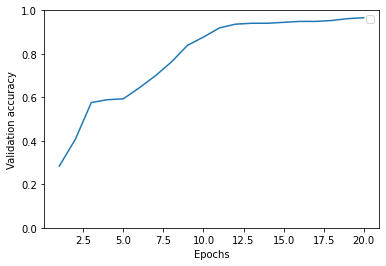

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/user/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.9.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/user/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/user/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23"

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.493229,0.560000
2,No log,2.716640,0.560000
3,No log,2.277291,0.560000
4,No log,2.055830,0.560000
5,No log,1.983874,0.560000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in 

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

In [51]:
generate_embeddings(bird_train_classes[:5], bird_test_classes[:5], birds, 'birds')
# generate_embeddings(flower_train_classes, flower_test_classes, flowers, 'flowers')